## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 7 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp017'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 8 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([8, 224, 224])

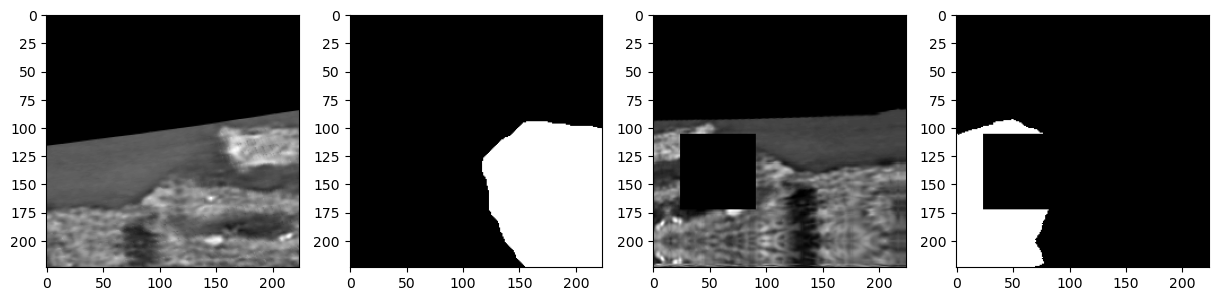

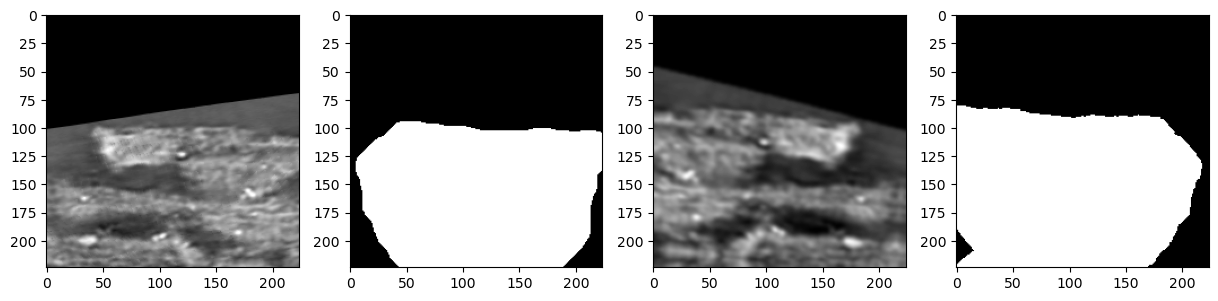

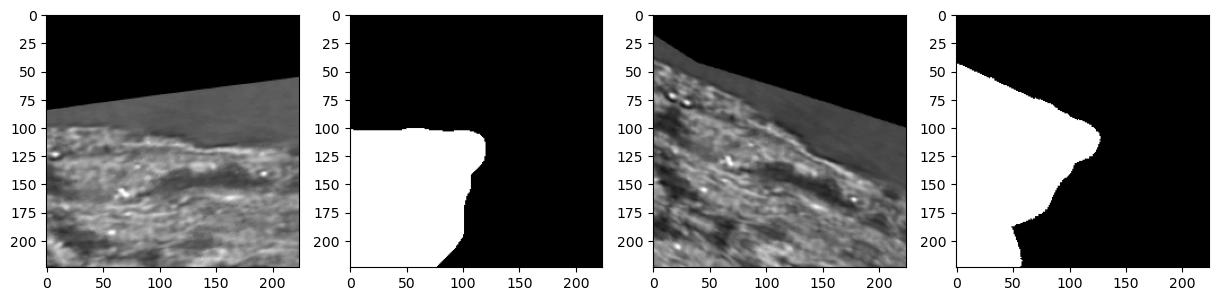

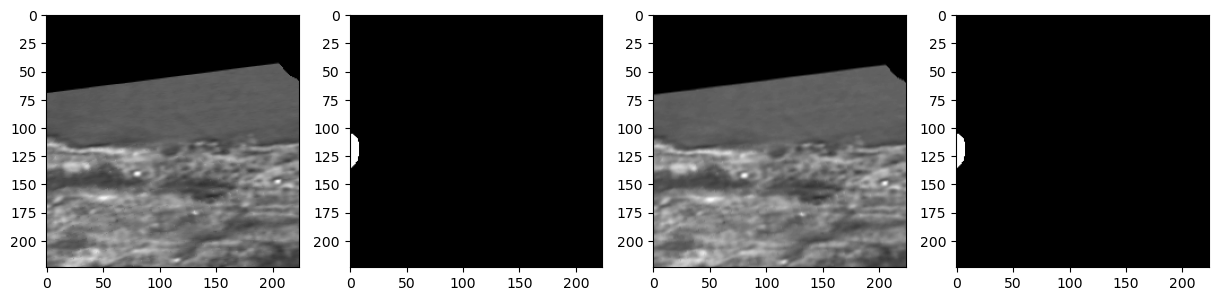

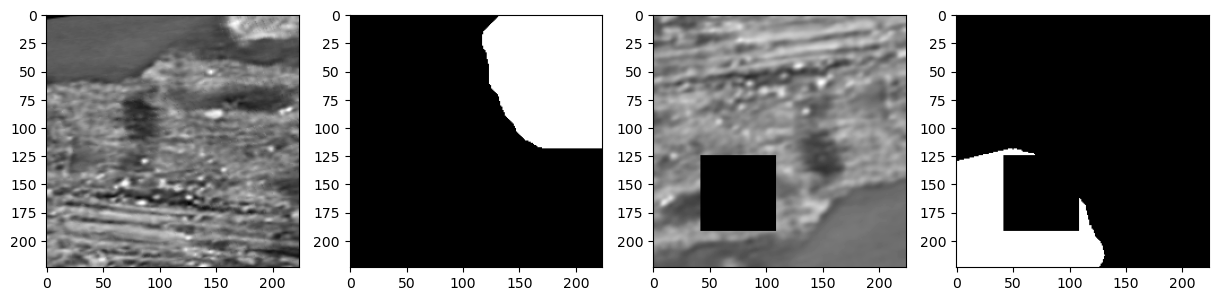

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48105

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1422995414689651
th: 0.15, fbeta: 0.1724698176016768
th: 0.2, fbeta: 0.23897897153530645
th: 0.25, fbeta: 0.26287668282586873
th: 0.3, fbeta: 0.285664571409748
th: 0.35, fbeta: 0.30431324597082576
th: 0.4, fbeta: 0.3072162888573204
th: 0.45, fbeta: 0.26905546610251585


best_th: 0.4, fbeta: 0.3072162888573204
Epoch 1 - avg_train_loss: 0.4163  avg_val_loss: 0.3805  time: 165s
Epoch 1 - avgScore: 0.3072
Epoch 1 - Save Best Score: 0.3072 Model
Epoch 1 - Save Best Loss: 0.3805 Model


th: 0.5, fbeta: 0.16935972609610353


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.15886565727652016
th: 0.15, fbeta: 0.247266123744359
th: 0.2, fbeta: 0.29645949194779825
th: 0.25, fbeta: 0.3360518757207199
th: 0.3, fbeta: 0.3407127746617852
th: 0.35, fbeta: 0.29728381986443964
th: 0.4, fbeta: 0.21145855253918414
th: 0.45, fbeta: 0.11290020721853175


best_th: 0.3, fbeta: 0.3407127746617852
Epoch 2 - avg_train_loss: 0.3123  avg_val_loss: 0.3431  time: 167s
Epoch 2 - avgScore: 0.3407
Epoch 2 - Save Best Score: 0.3407 Model
Epoch 2 - Save Best Loss: 0.3431 Model


th: 0.5, fbeta: 0.04184308336383703


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.35470295408915753
th: 0.15, fbeta: 0.35802042921118926
th: 0.2, fbeta: 0.30739374891045046
th: 0.25, fbeta: 0.2525739916394367
th: 0.3, fbeta: 0.20388872921936552
th: 0.35, fbeta: 0.1632162568418753
th: 0.4, fbeta: 0.12864164942534778
th: 0.45, fbeta: 0.09995452803153401


best_th: 0.15, fbeta: 0.35802042921118926
Epoch 3 - avg_train_loss: 0.2328  avg_val_loss: 0.3513  time: 166s
Epoch 3 - avgScore: 0.3580
Epoch 3 - Save Best Score: 0.3580 Model
Epoch 3 - Save Best Loss: 0.3513 Model


th: 0.5, fbeta: 0.07801211574840561


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3553200981374917
th: 0.15, fbeta: 0.3923941867385306
th: 0.2, fbeta: 0.40331944593968466
th: 0.25, fbeta: 0.39894284007392555
th: 0.3, fbeta: 0.3816154989778427
th: 0.35, fbeta: 0.35936618713808527
th: 0.4, fbeta: 0.3317993298600888
th: 0.45, fbeta: 0.3000470543366143


best_th: 0.2, fbeta: 0.40331944593968466
Epoch 4 - avg_train_loss: 0.1957  avg_val_loss: 0.3353  time: 165s
Epoch 4 - avgScore: 0.4033
Epoch 4 - Save Best Score: 0.4033 Model
Epoch 4 - Save Best Loss: 0.3353 Model


th: 0.5, fbeta: 0.2640872012862807


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41986180292606196
th: 0.15, fbeta: 0.42995542399072356
th: 0.2, fbeta: 0.4216278666668928
th: 0.25, fbeta: 0.4069127929948995
th: 0.3, fbeta: 0.38384883041149637
th: 0.35, fbeta: 0.3527441037168168
th: 0.4, fbeta: 0.3177149594289634
th: 0.45, fbeta: 0.2812417410611427


best_th: 0.15, fbeta: 0.42995542399072356
Epoch 5 - avg_train_loss: 0.1810  avg_val_loss: 0.3847  time: 168s
Epoch 5 - avgScore: 0.4300
Epoch 5 - Save Best Score: 0.4300 Model
Epoch 5 - Save Best Loss: 0.3847 Model


th: 0.5, fbeta: 0.24375653741855183


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3703469695167993
th: 0.15, fbeta: 0.3487695384220435
th: 0.2, fbeta: 0.29949854906844037
th: 0.25, fbeta: 0.2530763934164415
th: 0.3, fbeta: 0.21062306328823419
th: 0.35, fbeta: 0.17466304702219052
th: 0.4, fbeta: 0.1409866937397762
th: 0.45, fbeta: 0.11131282739074169


best_th: 0.1, fbeta: 0.3703469695167993
Epoch 6 - avg_train_loss: 0.1677  avg_val_loss: 0.4742  time: 167s
Epoch 6 - avgScore: 0.3703


th: 0.5, fbeta: 0.08441991380084571


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41740566516798944
th: 0.15, fbeta: 0.4225101482320458
th: 0.2, fbeta: 0.4120780156276014
th: 0.25, fbeta: 0.39468316653774793
th: 0.3, fbeta: 0.3696435640856233
th: 0.35, fbeta: 0.3396723240652743
th: 0.4, fbeta: 0.30508776396620024
th: 0.45, fbeta: 0.2741406527660968


best_th: 0.15, fbeta: 0.4225101482320458
Epoch 7 - avg_train_loss: 0.1523  avg_val_loss: 0.4746  time: 165s
Epoch 7 - avgScore: 0.4225


th: 0.5, fbeta: 0.24243753771394486


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35243305588171003
th: 0.15, fbeta: 0.3299303919853015
th: 0.2, fbeta: 0.3016591397981729
th: 0.25, fbeta: 0.27630010926702747
th: 0.3, fbeta: 0.2517346487911188
th: 0.35, fbeta: 0.22852358442699156
th: 0.4, fbeta: 0.2025420117116937
th: 0.45, fbeta: 0.1787896400052224


best_th: 0.1, fbeta: 0.35243305588171003
Epoch 8 - avg_train_loss: 0.1439  avg_val_loss: 0.4875  time: 165s
Epoch 8 - avgScore: 0.3524


th: 0.5, fbeta: 0.15555091039760557


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4198347485151878
th: 0.15, fbeta: 0.4168766561728451
th: 0.2, fbeta: 0.408414108161307
th: 0.25, fbeta: 0.39140265831548476
th: 0.3, fbeta: 0.36818266123358734
th: 0.35, fbeta: 0.3438520296387175
th: 0.4, fbeta: 0.31718970542390423
th: 0.45, fbeta: 0.2878597301731269


best_th: 0.1, fbeta: 0.4198347485151878
Epoch 9 - avg_train_loss: 0.1352  avg_val_loss: 0.4835  time: 166s
Epoch 9 - avgScore: 0.4198


th: 0.5, fbeta: 0.25675046898020965


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.394118322949143
th: 0.15, fbeta: 0.414514764259996
th: 0.2, fbeta: 0.428151256633017
th: 0.25, fbeta: 0.43825739774803607
th: 0.3, fbeta: 0.4454607204955494
th: 0.35, fbeta: 0.45048865929768467
th: 0.4, fbeta: 0.4513600300954971
th: 0.45, fbeta: 0.4488439590724176


best_th: 0.4, fbeta: 0.4513600300954971
Epoch 10 - avg_train_loss: 0.1259  avg_val_loss: 0.4401  time: 165s
Epoch 10 - avgScore: 0.4514
Epoch 10 - Save Best Score: 0.4514 Model
Epoch 10 - Save Best Loss: 0.4401 Model


th: 0.5, fbeta: 0.44332273281956247


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41225825340426375
th: 0.15, fbeta: 0.38477471956397385
th: 0.2, fbeta: 0.3501519853298193
th: 0.25, fbeta: 0.3172345733720698
th: 0.3, fbeta: 0.28860023283130326
th: 0.35, fbeta: 0.26197390677844545
th: 0.4, fbeta: 0.23384757361235398
th: 0.45, fbeta: 0.20483009207717912


best_th: 0.1, fbeta: 0.41225825340426375
Epoch 11 - avg_train_loss: 0.1160  avg_val_loss: 0.6039  time: 167s
Epoch 11 - avgScore: 0.4123


th: 0.5, fbeta: 0.17626115493711586


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39051976389218285
th: 0.15, fbeta: 0.3745301268657447
th: 0.2, fbeta: 0.3535649965928443
th: 0.25, fbeta: 0.3331521530672481
th: 0.3, fbeta: 0.3124611543642525
th: 0.35, fbeta: 0.28881223056265487
th: 0.4, fbeta: 0.26607900657470696
th: 0.45, fbeta: 0.24298396490388283


best_th: 0.1, fbeta: 0.39051976389218285
Epoch 12 - avg_train_loss: 0.1094  avg_val_loss: 0.5462  time: 166s
Epoch 12 - avgScore: 0.3905


th: 0.5, fbeta: 0.21836916756556274


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3518799457543448
th: 0.15, fbeta: 0.3469834255490689
th: 0.2, fbeta: 0.3396515588176746
th: 0.25, fbeta: 0.3268679359517343
th: 0.3, fbeta: 0.3142981422056771
th: 0.35, fbeta: 0.30010861847366166
th: 0.4, fbeta: 0.2837994492548663
th: 0.45, fbeta: 0.2636490325270713


best_th: 0.1, fbeta: 0.3518799457543448
Epoch 13 - avg_train_loss: 0.1027  avg_val_loss: 0.5467  time: 167s
Epoch 13 - avgScore: 0.3519


th: 0.5, fbeta: 0.24061747857170698


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3373827075525591
th: 0.15, fbeta: 0.32120988701150727
th: 0.2, fbeta: 0.30245253409188144
th: 0.25, fbeta: 0.2815123772011999
th: 0.3, fbeta: 0.2587317644645422
th: 0.35, fbeta: 0.236898880971953
th: 0.4, fbeta: 0.21316680130380317
th: 0.45, fbeta: 0.18926362103675537


best_th: 0.1, fbeta: 0.3373827075525591
Epoch 14 - avg_train_loss: 0.0947  avg_val_loss: 0.6528  time: 165s
Epoch 14 - avgScore: 0.3374


th: 0.5, fbeta: 0.16467662677614625


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38166282494097264
th: 0.15, fbeta: 0.3691703325159688
th: 0.2, fbeta: 0.3524065800851378
th: 0.25, fbeta: 0.33139086376818416
th: 0.3, fbeta: 0.30817682256676954
th: 0.35, fbeta: 0.284844763393453
th: 0.4, fbeta: 0.26080450820777923
th: 0.45, fbeta: 0.23481123001756793


best_th: 0.1, fbeta: 0.38166282494097264
Epoch 15 - avg_train_loss: 0.0882  avg_val_loss: 0.6676  time: 167s
Epoch 15 - avgScore: 0.3817


th: 0.5, fbeta: 0.20803124363631895


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3223556822614212
th: 0.15, fbeta: 0.2883015376610547
th: 0.2, fbeta: 0.25754383578889767
th: 0.25, fbeta: 0.22681905500595223
th: 0.3, fbeta: 0.19871133932703966
th: 0.35, fbeta: 0.17226991504594952
th: 0.4, fbeta: 0.14835138269349188
th: 0.45, fbeta: 0.12677259948712885


best_th: 0.1, fbeta: 0.3223556822614212
Epoch 16 - avg_train_loss: 0.0825  avg_val_loss: 0.7128  time: 166s
Epoch 16 - avgScore: 0.3224


th: 0.5, fbeta: 0.10642765271228646


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3855086191326819
th: 0.15, fbeta: 0.3712641046564188
th: 0.2, fbeta: 0.35201829372176524
th: 0.25, fbeta: 0.3260929683234929
th: 0.3, fbeta: 0.3020464960879102
th: 0.35, fbeta: 0.2780835869183533
th: 0.4, fbeta: 0.2544290370726023
th: 0.45, fbeta: 0.22959580216620598


best_th: 0.1, fbeta: 0.3855086191326819
Epoch 17 - avg_train_loss: 0.0787  avg_val_loss: 0.6573  time: 166s
Epoch 17 - avgScore: 0.3855


th: 0.5, fbeta: 0.20276388043822646


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3719652974415495
th: 0.15, fbeta: 0.3586996623423936
th: 0.2, fbeta: 0.3436829803791646
th: 0.25, fbeta: 0.32540780272535436
th: 0.3, fbeta: 0.3055753238595573
th: 0.35, fbeta: 0.28224387554649666
th: 0.4, fbeta: 0.2591596635255517
th: 0.45, fbeta: 0.23562795037218723


best_th: 0.1, fbeta: 0.3719652974415495
Epoch 18 - avg_train_loss: 0.0755  avg_val_loss: 0.7412  time: 165s
Epoch 18 - avgScore: 0.3720


th: 0.5, fbeta: 0.21348214815679029


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3641120981924263
th: 0.15, fbeta: 0.35382915294387046
th: 0.2, fbeta: 0.33917637059543915
th: 0.25, fbeta: 0.31860781190637405
th: 0.3, fbeta: 0.2958001164713736
th: 0.35, fbeta: 0.271340352263261
th: 0.4, fbeta: 0.24685199882502648
th: 0.45, fbeta: 0.22255288343960028


best_th: 0.1, fbeta: 0.3641120981924263
Epoch 19 - avg_train_loss: 0.0685  avg_val_loss: 0.7065  time: 166s
Epoch 19 - avgScore: 0.3641


th: 0.5, fbeta: 0.19894233045368473


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3980006101240651
th: 0.15, fbeta: 0.3894697617568892
th: 0.2, fbeta: 0.37888002474934124
th: 0.25, fbeta: 0.36183614609446224
th: 0.3, fbeta: 0.34518935439475845
th: 0.35, fbeta: 0.3272439325167109
th: 0.4, fbeta: 0.3066052548607105
th: 0.45, fbeta: 0.2842240273404067


best_th: 0.1, fbeta: 0.3980006101240651
Epoch 20 - avg_train_loss: 0.0677  avg_val_loss: 0.7412  time: 166s
Epoch 20 - avgScore: 0.3980


th: 0.5, fbeta: 0.25521810891683167


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31745370515518645
th: 0.15, fbeta: 0.30069251597541685
th: 0.2, fbeta: 0.28062887660648383
th: 0.25, fbeta: 0.2570574291750786
th: 0.3, fbeta: 0.23493896294345307
th: 0.35, fbeta: 0.20983847007718906
th: 0.4, fbeta: 0.18581698391834064
th: 0.45, fbeta: 0.1653113392790833


best_th: 0.1, fbeta: 0.31745370515518645
Epoch 21 - avg_train_loss: 0.0633  avg_val_loss: 0.8218  time: 165s
Epoch 21 - avgScore: 0.3175


th: 0.5, fbeta: 0.14373536913665344


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3640070900469558
th: 0.15, fbeta: 0.35845353900130744
th: 0.2, fbeta: 0.3486863475130557
th: 0.25, fbeta: 0.3339664541473018
th: 0.3, fbeta: 0.3166900639443428
th: 0.35, fbeta: 0.29881364447690917
th: 0.4, fbeta: 0.27900184580534226
th: 0.45, fbeta: 0.2556071107750038


best_th: 0.1, fbeta: 0.3640070900469558
Epoch 22 - avg_train_loss: 0.0616  avg_val_loss: 0.7828  time: 168s
Epoch 22 - avgScore: 0.3640


th: 0.5, fbeta: 0.22828531756774126


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35560305920846186
th: 0.15, fbeta: 0.34772341297061465
th: 0.2, fbeta: 0.33342645321709685
th: 0.25, fbeta: 0.31627762973024326
th: 0.3, fbeta: 0.2986184580299254
th: 0.35, fbeta: 0.27802305686775414
th: 0.4, fbeta: 0.254494506930872
th: 0.45, fbeta: 0.23060220527845063


best_th: 0.1, fbeta: 0.35560305920846186
Epoch 23 - avg_train_loss: 0.0590  avg_val_loss: 0.8113  time: 167s
Epoch 23 - avgScore: 0.3556


th: 0.5, fbeta: 0.20488687677299358


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3419296532303652
th: 0.15, fbeta: 0.3251181677927991
th: 0.2, fbeta: 0.3056025384291896
th: 0.25, fbeta: 0.28245326799055087
th: 0.3, fbeta: 0.2610751474920448
th: 0.35, fbeta: 0.23924784331710383
th: 0.4, fbeta: 0.21694778874128706
th: 0.45, fbeta: 0.19329805952961437


best_th: 0.1, fbeta: 0.3419296532303652
Epoch 24 - avg_train_loss: 0.0534  avg_val_loss: 0.8653  time: 167s
Epoch 24 - avgScore: 0.3419


th: 0.5, fbeta: 0.16668678567642878


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3084886700443227
th: 0.15, fbeta: 0.2929092397904006
th: 0.2, fbeta: 0.2728412339739273
th: 0.25, fbeta: 0.24793039654534074
th: 0.3, fbeta: 0.2244944571211016
th: 0.35, fbeta: 0.20432878382149453
th: 0.4, fbeta: 0.18387570212607512
th: 0.45, fbeta: 0.16367825362975325


best_th: 0.1, fbeta: 0.3084886700443227
Epoch 25 - avg_train_loss: 0.0526  avg_val_loss: 0.8949  time: 166s
Epoch 25 - avgScore: 0.3085


th: 0.5, fbeta: 0.14034688899127992


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36047244723534316
th: 0.15, fbeta: 0.3502186073319792
th: 0.2, fbeta: 0.3355455908763241
th: 0.25, fbeta: 0.3177313266456388
th: 0.3, fbeta: 0.3002222094718994
th: 0.35, fbeta: 0.28201184688167336
th: 0.4, fbeta: 0.26069932542195995
th: 0.45, fbeta: 0.23654357850052704


best_th: 0.1, fbeta: 0.36047244723534316
Epoch 26 - avg_train_loss: 0.0514  avg_val_loss: 0.8229  time: 167s
Epoch 26 - avgScore: 0.3605


th: 0.5, fbeta: 0.21000948708554562


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34859442657794143
th: 0.15, fbeta: 0.3388981971270472
th: 0.2, fbeta: 0.32548182844334156
th: 0.25, fbeta: 0.3058451009740398
th: 0.3, fbeta: 0.2872418336043413
th: 0.35, fbeta: 0.26987651991143885
th: 0.4, fbeta: 0.25037642913258223
th: 0.45, fbeta: 0.22736499537282712


best_th: 0.1, fbeta: 0.34859442657794143
Epoch 27 - avg_train_loss: 0.0500  avg_val_loss: 0.8647  time: 167s
Epoch 27 - avgScore: 0.3486


th: 0.5, fbeta: 0.20104650400978102


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3130026882555036
th: 0.15, fbeta: 0.29937465791018625
th: 0.2, fbeta: 0.280759942537517
th: 0.25, fbeta: 0.25704710387309804
th: 0.3, fbeta: 0.23757409215666614
th: 0.35, fbeta: 0.2169697236023345
th: 0.4, fbeta: 0.19572719565269375
th: 0.45, fbeta: 0.17521350095934246


best_th: 0.1, fbeta: 0.3130026882555036
Epoch 28 - avg_train_loss: 0.0497  avg_val_loss: 0.9397  time: 169s
Epoch 28 - avgScore: 0.3130


th: 0.5, fbeta: 0.1522696724749965


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34421355268234965
th: 0.15, fbeta: 0.3312460655227195
th: 0.2, fbeta: 0.3166047094815388
th: 0.25, fbeta: 0.29486175941317966
th: 0.3, fbeta: 0.2765109644788743
th: 0.35, fbeta: 0.25792839568466014
th: 0.4, fbeta: 0.23783072159697746
th: 0.45, fbeta: 0.21590494733663637


best_th: 0.1, fbeta: 0.34421355268234965
Epoch 29 - avg_train_loss: 0.0486  avg_val_loss: 0.8897  time: 171s
Epoch 29 - avgScore: 0.3442


th: 0.5, fbeta: 0.19230439006651107


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3602314333896618
th: 0.15, fbeta: 0.34928687947516734
th: 0.2, fbeta: 0.33637385819779714
th: 0.25, fbeta: 0.3178568124474128
th: 0.3, fbeta: 0.29780426939978005
th: 0.35, fbeta: 0.2803462855015446
th: 0.4, fbeta: 0.2614350668768033
th: 0.45, fbeta: 0.24161890067605682


best_th: 0.1, fbeta: 0.3602314333896618
Epoch 30 - avg_train_loss: 0.0476  avg_val_loss: 0.8681  time: 173s
Epoch 30 - avgScore: 0.3602


th: 0.5, fbeta: 0.2175709110494543


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.394118322949143
th: 0.15, fbeta: 0.414514764259996
th: 0.2, fbeta: 0.428151256633017
th: 0.25, fbeta: 0.43825739774803607
th: 0.3, fbeta: 0.4454607204955494
th: 0.35, fbeta: 0.45048865929768467
th: 0.4, fbeta: 0.4513600300954971
th: 0.45, fbeta: 0.4488439590724176


best_th: 0.4, fbeta: 0.4513600300954971


th: 0.5, fbeta: 0.44332273281956247


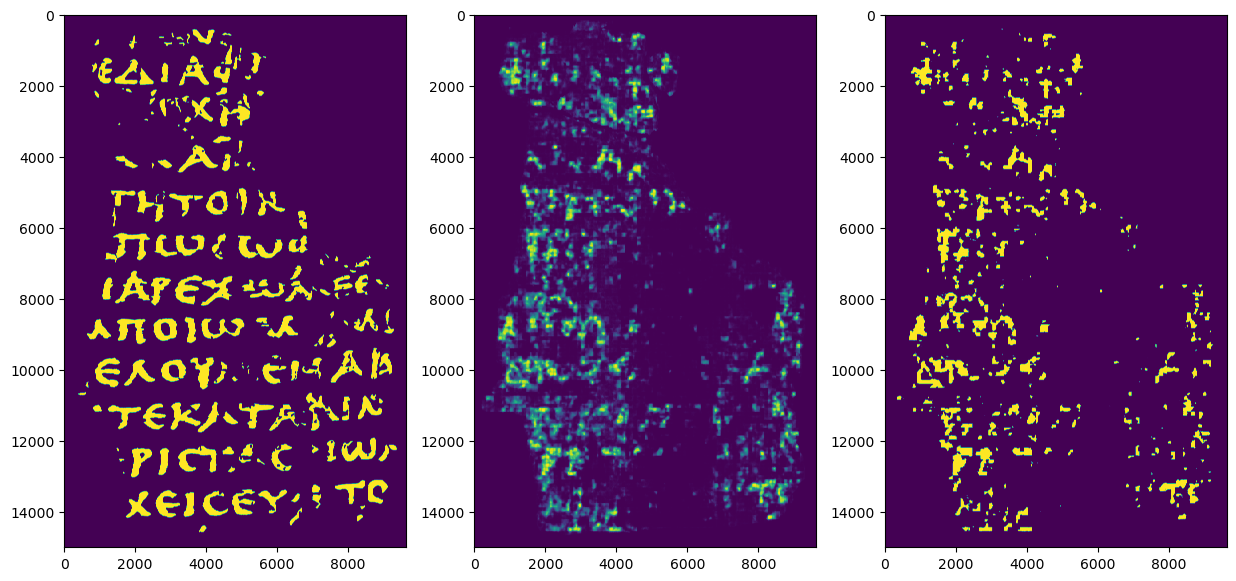

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.15926121e+08, 6.24344800e+06, 3.95534800e+06, 2.85964000e+06,
        2.28146600e+06, 1.78146500e+06, 1.51635800e+06, 1.35212900e+06,
        1.20960600e+06, 1.05118500e+06, 8.88453000e+05, 8.01168000e+05,
        7.60379000e+05, 7.02987000e+05, 6.71084000e+05, 6.35888000e+05,
        6.03808000e+05, 5.86875000e+05, 4.75259000e+05, 2.54389000e+05]),
 array([1.66492751e-06, 4.98062729e-02, 9.96108809e-02, 1.49415489e-01,
        1.99220097e-01, 2.49024705e-01, 2.98829313e-01, 3.48633921e-01,
        3.98438529e-01, 4.48243137e-01, 4.98047745e-01, 5.47852353e-01,
        5.97656961e-01, 6.47461569e-01, 6.97266177e-01, 7.47070785e-01,
        7.96875393e-01, 8.46680001e-01, 8.96484609e-01, 9.46289217e-01,
        9.96093825e-01]),
 <BarContainer object of 20 artists>)

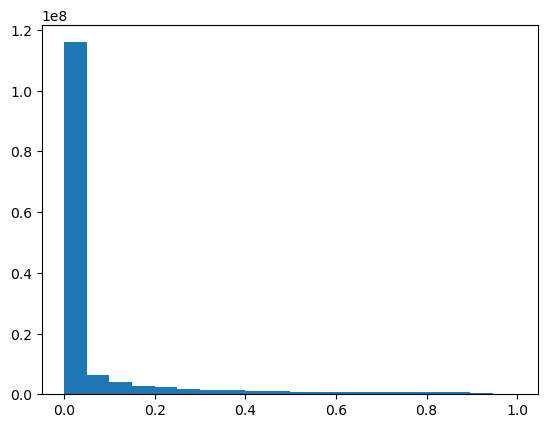

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000